In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


sns.set_theme(
    rc={
        'grid.linewidth': 0.6, 
        'grid.color': 'white',
        'axes.linewidth': 2, 
        'axes.facecolor': '#ECECEC',
        'axes.labelcolor': '#000000',
        'figure.facecolor': '#f7f7f7',
        'xtick.color': '#000000', 
        'ytick.color': '#000000'
    }
)

In [3]:
def rainplots(df: pd.DataFrame, cat_col: str, x_col: list,
              rows: int = 1, cols: int = 2, figsize: tuple = (12, 5), dpi: int = 200,
              ax_labelsize: int = 10, x_labelsize: int = 9, y_labelsize: int = 9):
    """EDA rainplots.

    Parameters:
        df: pandas pd.DataFrame.
        cat_col: categorical column (target column for binary classification).
        x_col: list of numeric columns for plotting histograms.
    """

    with plt.rc_context(rc={'figure.dpi': dpi, 
                            'axes.labelsize': ax_labelsize, 
                            'xtick.labelsize': x_labelsize, 'ytick.labelsize': y_labelsize}):
    
      fig, ax = plt.subplots(rows, cols, figsize=figsize)
    
      for idx, (col, axes) in list(enumerate(zip(x_col, ax.flatten()))):
          # Violinplot
          sns.violinplot(ax=axes, x=df[cat_col].astype('category'), y=df[col], hue=df[cat_col],
                         palette='seismic', density_norm='width', linewidth=1,
                         inner=None)
        
          plt.setp(axes.collections, alpha=0.5)
        
          # Stripplot
          sns.stripplot(ax=axes, x=df[cat_col].astype('category'), y=df[col], hue=df[cat_col],
                        palette='seismic', s=1.5, jitter=0.125)
    
          # Mean bars
          sns.pointplot(ax=axes, x=df[cat_col],
                        y=df[col],
                        color='#37374f',
                        estimator=np.mean, errorbar='sd',
                        err_kws={'linewidth': 1.5}, capsize=0.1, linewidth=1.5)

      # Remove empty plots
      [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]

    plt.tight_layout(pad=1)
    plt.show()

In [4]:
# Reading the Parquet file using PyArrow
with open('.\\data\\output_speech_us_central_bank_v2.parquet', 'rb') as handle:
    text = pq.read_table(handle).to_pandas()

text = text[['speech_date', 'target_label']].rename(columns={'speech_date': 'date'})
# text = text.loc[text['date'] >= '2012-01-01']
            
with open('.\\data\\us_macroeconomic_indicators.parquet', 'rb') as handle:
    macroeconomic_indicators = pq.read_table(handle).to_pandas()

In [5]:
import pandas as pd
import yfinance as yf

stocks = {
    "Banks and Financials": ["JPM", "BAC"],
    "REITs": ["PLD", "AMT"],
    "Tech Growth Stocks": ["AMZN"],
    "High-Yield Dividend Stocks": ["PG"],
    "SP500": ["^GSPC"]
}

all_tickers = [ticker for sector in stocks.values() for ticker in sector]
data = yf.download(all_tickers, period="max", group_by="ticker", auto_adjust=True).reset_index()

# Extract close prices
close_prices = []

for ticker in all_tickers:
    if ticker in data.columns.get_level_values(0):
        stock_data = data[[("Date", ""), (ticker, "Close")]].copy()
        stock_data.columns = ["Date", "Close"]
        stock_data["Ticker"] = ticker
        close_prices.append(stock_data)

close_prices_df = pd.concat(close_prices, ignore_index=True)
close_prices_df = close_prices_df.pivot_table(values='Close', index='Date', columns=['Ticker']).reset_index()
close_prices_df = close_prices_df.rename(columns={'Date': 'date', '^GSPC': 'SP500'})

# Recover weekends
date_range = pd.date_range(start=text['date'].min(), end=text['date'].max())
close_prices_df.set_index('date', inplace=True)
close_prices_df = close_prices_df.reindex(date_range)
close_prices_df.index.name = 'date'
close_prices_df.reset_index(inplace=True)

# Fill missing data
close_prices_df.fillna(method='ffill', inplace=True)

# Remove trend
for col in close_prices_df.columns[1:]:
    close_prices_df[f'{col}_diff'] = close_prices_df[col] - close_prices_df[col].shift(1)

[**************        29%%                      ]  2 of 7 completed

c:\Python_projects\0_venvs\venv_base\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Python_projects\0_venvs\venv_base\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Python_projects\0_venvs\venv_base\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[********************* 43%%                      ]  3 of 7 completed

c:\Python_projects\0_venvs\venv_base\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Python_projects\0_venvs\venv_base\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[**********************57%%*                     ]  4 of 7 completed

c:\Python_projects\0_venvs\venv_base\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Python_projects\0_venvs\venv_base\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%%**********************]  7 of 7 completed


C:\conda_tmp\ipykernel_18800\3526147381.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices_df.fillna(method='ffill', inplace=True)


In [6]:
# Merge datasets
df = text.merge(close_prices_df, how='left', on='date').sort_values(by='date').reset_index(drop=True)

In [7]:
mean_std = []

for col in df.columns[-7:]:
    mean_std.append(df.groupby(['target_label'], as_index=False)[col].mean().T.iloc[1:])
    mean_std.append(df.groupby(['target_label'], as_index=False)[col].std().T.iloc[1:])

mean_std = pd.concat(mean_std)
mean_std['Statistic'] = ['Avg', 'Std']*7
mean_std.columns = ['Negative', 'Positive', 'Statistic']

In [8]:
mean_std

,Negative,Positive,Statistic
AMT_diff,-0.031444,0.063577,Avg
AMT_diff,1.930163,1.883619,Std
AMZN_diff,0.098718,0.012943,Avg
AMZN_diff,1.144836,1.606287,Std
BAC_diff,-0.082652,0.004272,Avg
BAC_diff,0.670602,0.419665,Std
JPM_diff,-0.018597,0.045851,Avg
JPM_diff,1.380232,1.271257,Std
PG_diff,-0.002127,-0.016024,Avg
PG_diff,0.925907,0.84132,Std


In [10]:
# Test
for col in df.columns[-7:]:
    print(col)
    ttest = sc.ttest_ind(
        df.loc[df['target_label'] == 'Negative', col].dropna(), 
        df.loc[df['target_label'] == 'Positive', col].dropna(), 
        equal_var=False, alternative='two-sided')[1]
    
    if ttest < 0.1:
        print(f'* Significant difference detected  | p-value: {ttest:.4f} | alpla: 0.1')
    else:
        print(f'NO significant difference detected | p-value: {ttest:.4f} | alpla: 0.1')
    print('--'*30)
    a.append(ttest)
    b.append(col)

AMT_diff
NO significant difference detected | p-value: 0.4801 | alpla: 0.1
------------------------------------------------------------
AMZN_diff
NO significant difference detected | p-value: 0.3362 | alpla: 0.1
------------------------------------------------------------
BAC_diff
* Significant difference detected  | p-value: 0.0459 | alpla: 0.1
------------------------------------------------------------
JPM_diff
NO significant difference detected | p-value: 0.4974 | alpla: 0.1
------------------------------------------------------------
PG_diff
NO significant difference detected | p-value: 0.8268 | alpla: 0.1
------------------------------------------------------------
PLD_diff
NO significant difference detected | p-value: 0.6973 | alpla: 0.1
------------------------------------------------------------
SP500_diff
NO significant difference detected | p-value: 0.5241 | alpla: 0.1
------------------------------------------------------------


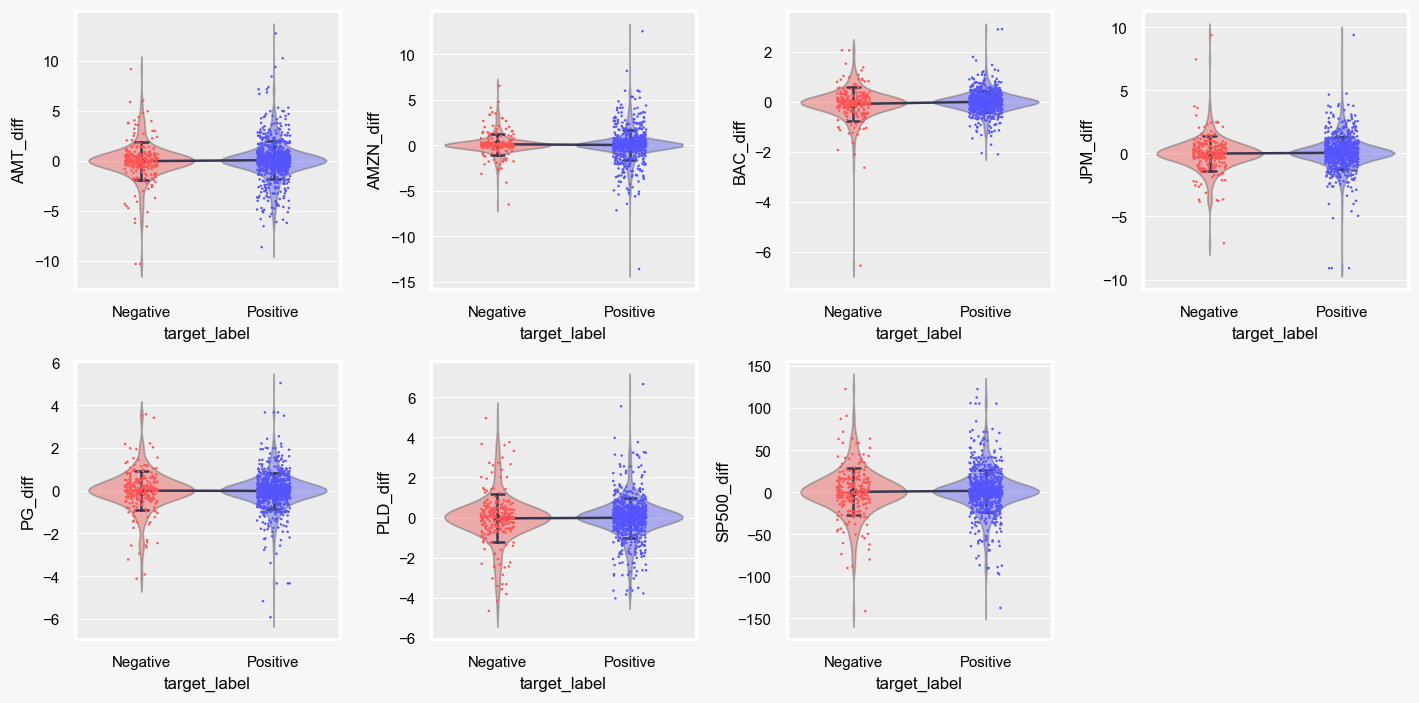

In [9]:
rainplots(df=df, cat_col='target_label', x_col=df.columns[-7:],
          rows=2, cols=4, figsize=(12, 6), dpi=120)

## Regression

In [ ]:
# Target
target_col = 'SP500'

# Stock and macroecon data
df_stock = (close_prices_df[['date', target_col]].merge(macroeconomic_indicators, how='left', on='date').
            sort_values(by='date').reset_index(drop=True)).dropna()

df_stock = df_stock.merge(text, how='left', on='date')
df_stock = df_stock.loc[(df_stock['date'] <= text['date'].max()) &
                        (df_stock['date'] >= text['date'].min())]
df_stock['announcement_sentiment'] = df_stock['target_label'].fillna('No announcement')
df_stock = df_stock.drop(['target_label'], axis=1).dropna().reset_index(drop=True)
df_stock['announcement_sentiment_lag30'] = df_stock['announcement_sentiment'].shift(30)
df_stock = df_stock.dropna()

# Column types
cat_cols = ['announcement_sentiment', 'announcement_sentiment_lag30']
num_cols = list(set(df_stock.columns) - set(cat_cols) - {target_col} - {'date'})

# Encoding
df_cat_cols = pd.get_dummies(df_stock[cat_cols].astype(object), drop_first=False,  dtype='float')
df_cat_cols = df_cat_cols.drop([x for x in df_cat_cols.columns if '_no' in x or '_No' in x], axis=1)
X = pd.concat([df_cat_cols, df_stock[num_cols]], 
              axis=1, join='outer', ignore_index=False)

Y = df_stock[[target_col]]

# Saving
r_df = X
r_df[target_col] = Y
r_df.to_excel(f'./r_scripts/{target_col}.xlsx')

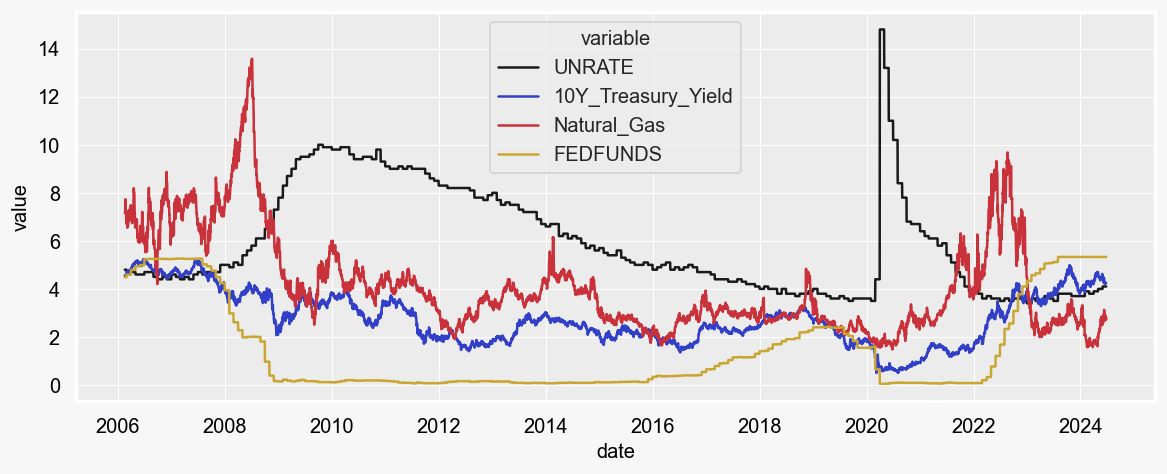

In [73]:
line_plot = df_stock[['date', 'UNRATE', '10Y_Treasury_Yield', 'Natural_Gas', 'FEDFUNDS']].melt(id_vars='date')

with plt.rc_context(rc={'figure.dpi': 120, 
                        'axes.labelsize': 12, 
                        'xtick.labelsize': 12, 'ytick.labelsize': 12,
                        'legend.fontsize': 12, 'legend.title_fontsize': 12}):

    fig, ax = plt.subplots(2, 1, figsize=(10, 7.5))
    
    # Biplots
    sns.lineplot(ax=ax[0], x=line_plot['date'], y=line_plot['value'], hue=line_plot['variable'],
                 palette=['k', '#323fc9', '#c9323a', '#c9a632'])
    
    ax[1].set_visible(False)

plt.tight_layout(pad=1)
plt.show()

In [53]:
# Get only numeric variables
X_rest = X.iloc[:, 4:-1]

# PCA
pca_pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=X_rest.shape[1]))])
pca_result = pca_pipeline.fit_transform(X_rest)
pca = pca_pipeline.named_steps['pca']

pca_columns = pd.DataFrame(pca_result, columns=[f'PC{x}' for x in range(X_rest.shape[1])])
df_pca = pd.concat([pca_columns, df_stock['announcement_sentiment'].reset_index(drop=True)], axis=1)

explained_variance = pca.explained_variance_ratio_ * 100

# Additional columns for plotting
df_pca['dot_size'] = [1 if x == 'No announcement' else 1.2 if x == 'Positive' else 1.4 for x in df_pca['announcement_sentiment']]
df_pca['announcement_sentiment'] = pd.Categorical(df_pca['announcement_sentiment'], 
                                                  categories=['No announcement', 'Positive', 'Negative'], ordered=True)
df_pca = df_pca.sort_values('announcement_sentiment')

In [55]:
pd.DataFrame(pca.components_, columns=X_rest.columns,
             index=[f'PC{x}' for x in range(1, 14)]).round(2).T

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
GDP,0.45,0.00,-0.06,0.04,0.06,-0.07,0.01,-0.05,0.09,-0.31,0.06,-0.35,0.75
UNRATE,-0.27,-0.10,-0.41,0.03,-0.51,0.00,-0.41,-0.08,0.52,-0.05,-0.18,-0.10,0.05
VIX,-0.09,-0.02,-0.27,0.71,0.09,0.23,0.53,-0.18,0.17,0.06,-0.03,-0.01,-0.00
Oil,-0.07,0.43,-0.26,-0.31,0.23,-0.51,0.35,-0.01,0.27,0.12,-0.34,0.08,0.04
CPIAUCSL,0.44,0.02,-0.12,0.03,0.02,-0.18,0.01,-0.05,0.14,-0.25,0.12,-0.48,-0.65
10Y_Treasury_Yield,-0.05,0.45,0.30,0.12,-0.42,-0.25,0.05,-0.50,-0.01,-0.12,0.39,0.17,0.01
CSUSHPINSA,0.42,0.14,0.03,0.15,0.04,0.16,-0.19,-0.03,0.08,-0.40,-0.41,0.60,-0.11
Gold,0.34,-0.05,-0.38,-0.14,-0.13,0.03,0.11,0.30,0.19,0.23,0.59,0.40,0.02
DXY,0.39,-0.15,0.16,0.19,0.06,-0.20,-0.26,-0.32,0.09,0.72,-0.16,0.01,0.03
Natural_Gas,-0.18,0.44,0.09,0.18,0.54,0.17,-0.43,0.11,0.35,0.04,0.29,-0.07,0.00


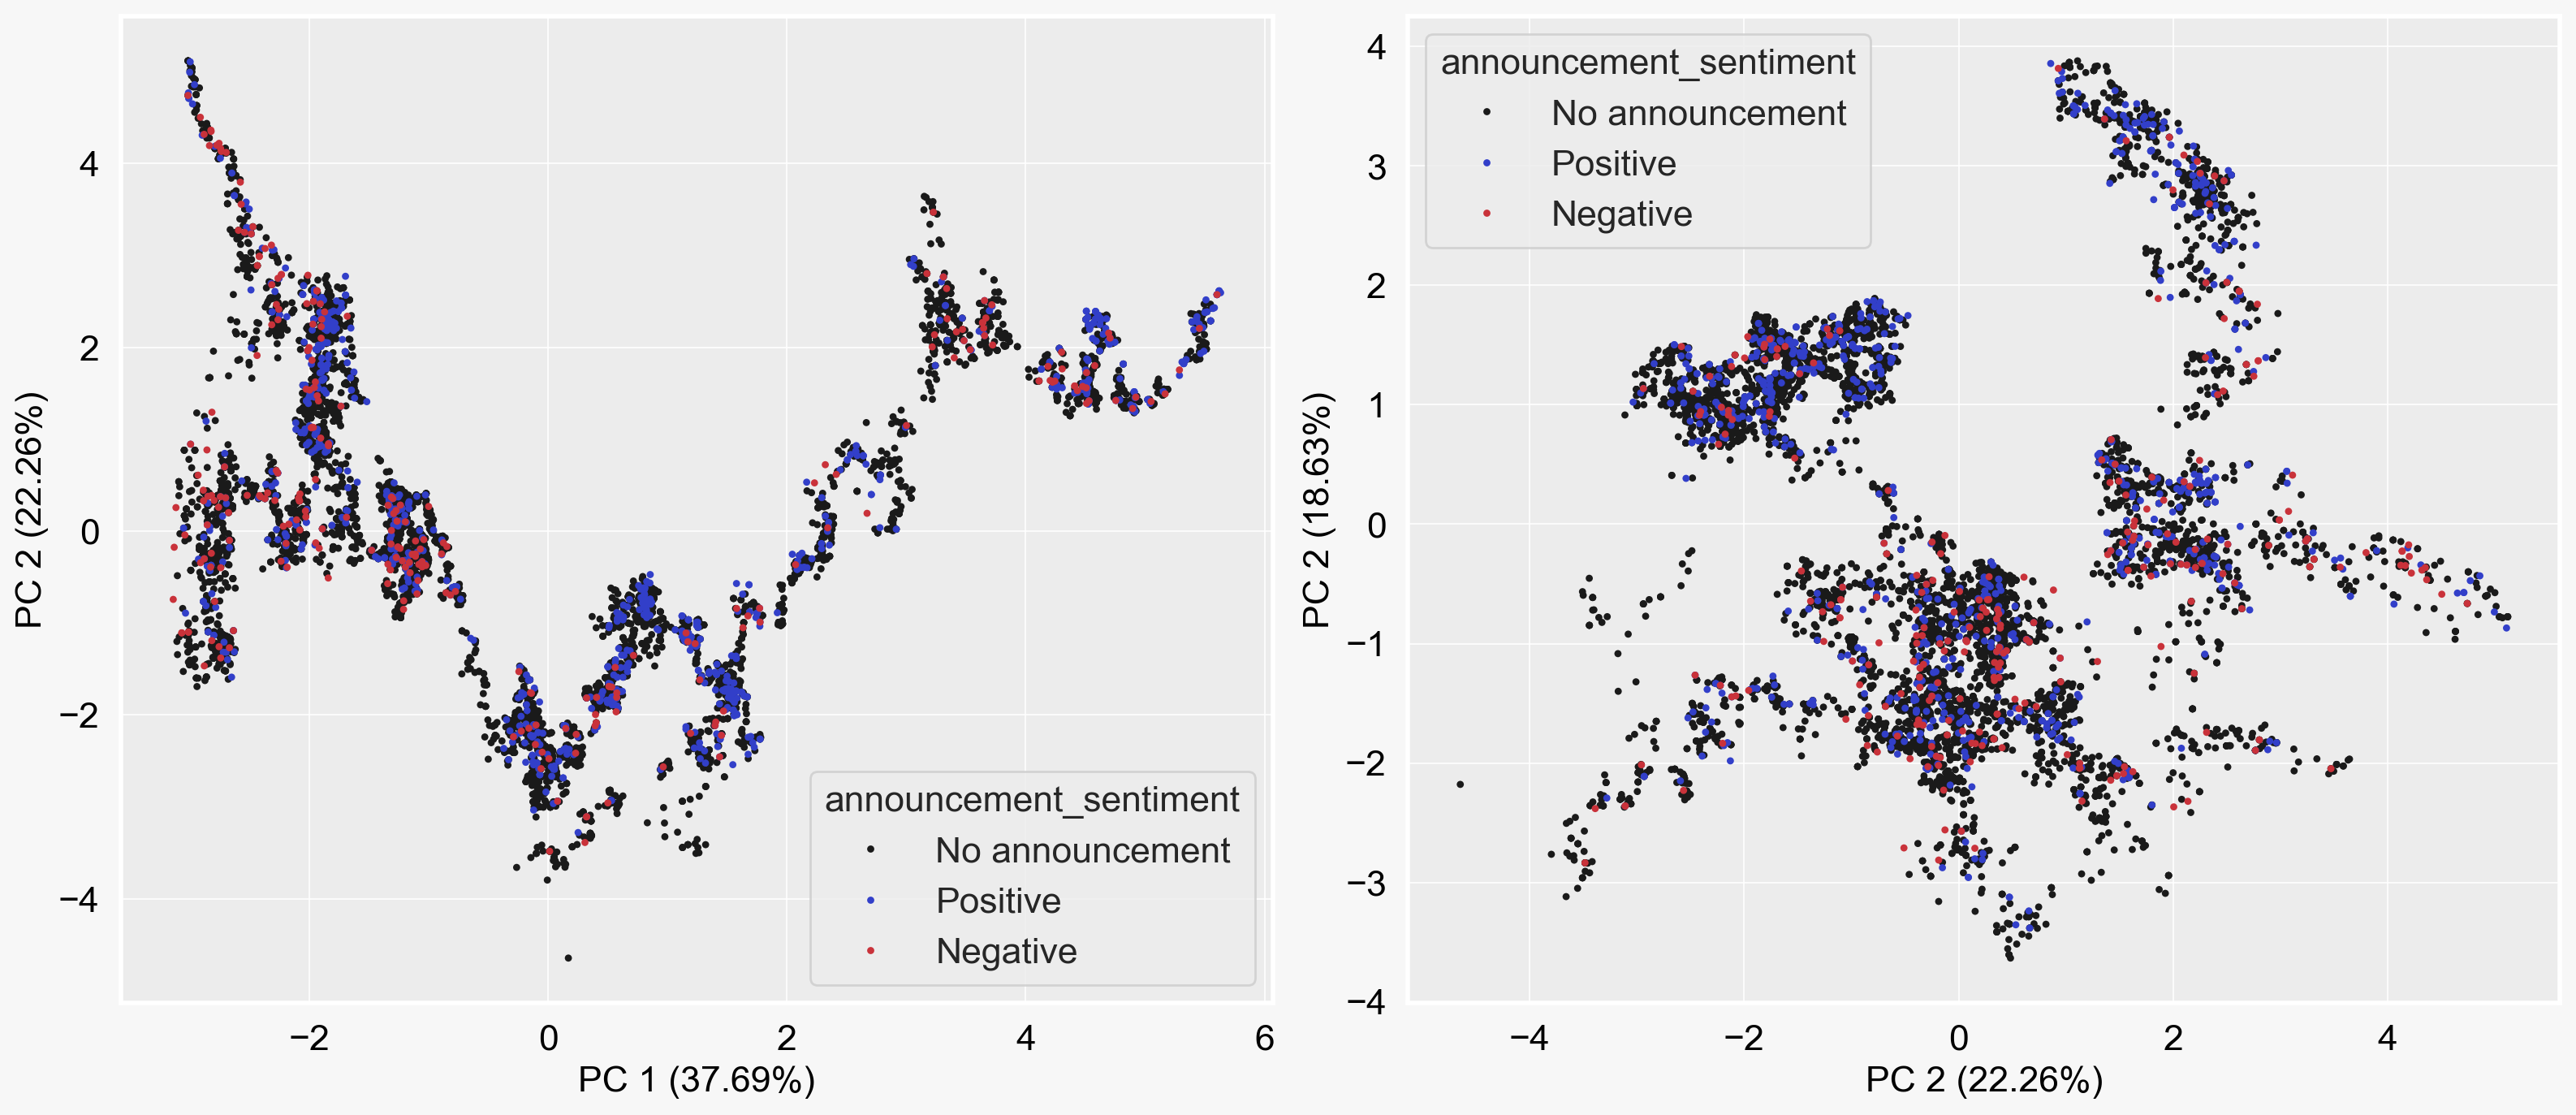

In [60]:
with plt.rc_context(rc={'figure.dpi': 200, 
                        'axes.labelsize': 16, 
                        'xtick.labelsize': 16, 'ytick.labelsize': 16,
                        'legend.fontsize': 16, 'legend.title_fontsize': 16}):

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    
    # Biplots
    sns.scatterplot(ax=ax[0], x=df_pca['PC0'], y=df_pca['PC1'], edgecolor='none', alpha=1, # size=df_pca['dot_size'],
                    palette=['k', '#323fc9', '#c9323a'], hue=df_pca['announcement_sentiment'], s=10)
    
    ax[0].set(xlabel='PC 1 (37.69%)', ylabel='PC 2 (22.26%)')
    
    sns.scatterplot(ax=ax[1], x=df_pca['PC1'], y=df_pca['PC2'], edgecolor='none', alpha=1, # size=df_pca['dot_size'],
                    palette=['k', '#323fc9', '#c9323a'], hue=df_pca['announcement_sentiment'], s=10)
    
    ax[1].set(xlabel='PC 2 (22.26%)', ylabel='PC 2 (18.63%)')

plt.tight_layout(pad=1)
plt.show()

In [ ]:
with plt.rc_context(rc={'figure.dpi': 200, 
                        'axes.labelsize': 16, 
                        'xtick.labelsize': 16, 'ytick.labelsize': 16,
                        'legend.fontsize': 16, 'legend.title_fontsize': 16}):

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    
    # Biplots
    sns.scatterplot(ax=ax[0], x=df_pca['PC0'], y=df_pca['PC1'], edgecolor='none', alpha=1, # size=df_pca['dot_size'],
                    palette=['k', '#323fc9', '#c9323a'], hue=df_pca['announcement_sentiment'], s=10)
    
    ax[0].set(xlabel='PC 1 (37.69%)', ylabel='PC 2 (22.26%)')
    
    sns.scatterplot(ax=ax[1], x=df_pca['PC1'], y=df_pca['PC2'], edgecolor='none', alpha=1, # size=df_pca['dot_size'],
                    palette=['k', '#323fc9', '#c9323a'], hue=df_pca['announcement_sentiment'], s=10)
    
    ax[1].set(xlabel='PC 2 (22.26%)', ylabel='PC 2 (18.63%)')

plt.tight_layout(pad=1)
plt.show()

In [ ]:
# Target
target_col = 'BAC'

# Stock and macroecon data
df_stock = (close_prices_df[['date', target_col]].merge(macroeconomic_indicators, how='left', on='date').
            sort_values(by='date').reset_index(drop=True)).dropna()

df_stock = df_stock.merge(text, how='left', on='date')
df_stock = df_stock.loc[(df_stock['date'] <= text['date'].max()) &
                        (df_stock['date'] >= text['date'].min())]
df_stock['announcement_sentiment'] = df_stock['target_label'].fillna('No announcement')
df_stock = df_stock.drop(['target_label'], axis=1).dropna().reset_index(drop=True)
df_stock['announcement_sentiment_lag30'] = df_stock['announcement_sentiment'].shift(30)
df_stock = df_stock.dropna()

# Column types
cat_cols = ['announcement_sentiment', 'announcement_sentiment_lag30']
num_cols = list(set(df_stock.columns) - set(cat_cols) - {target_col} - {'date'})

# Encoding
df_cat_cols = pd.get_dummies(df_stock[cat_cols].astype(object), drop_first=False,  dtype='float')
df_cat_cols = df_cat_cols.drop([x for x in df_cat_cols.columns if '_no' in x or '_No' in x], axis=1)
X = pd.concat([df_cat_cols, df_stock[num_cols]], 
              axis=1, join='outer', ignore_index=False)

Y = df_stock[[target_col]]

# Saving
r_df = X
r_df[target_col] = Y
r_df.to_excel(f'./r_scripts/{target_col}.xlsx')